In [143]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
import swarms
from random import randint, seed, uniform

from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON, KM

In [144]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def Mbol_to_L(M):
    return 10**(0.4*(4.74-M))

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
#         amin = star.d/pc*IWA# AU
#         amax = star.d/pc*OWA # AU
        amin = 0.01 # AU
        amax = 200 # AU
        a = loguniform(amin, amax)
        #print("a in notebook: {0:.3e}".format(a))
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)

def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  

def age_sampler():
    y = uniform(0, 1)
    age = inverse_cdf(y)
    if age > 100:
        return age_sampler()
    return age*1e6 * YEAR

In [145]:
def aoptChar(Lstar, Mstar, Tstar, Mtot, tage, dpl):
    star = swarms.Star(Lstar, Mstar, Tstar, d=dpl)
    planet = draw_planet(star, tage)
    if planet is None:
        return aoptChar(Mstar, Mtot, tage, dapl) # do it again
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.3 # eta
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4./pi

    return aopt11(star, Mtot, 1e6*YEAR, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi), star.Imag

In [146]:
def aopt11(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    return AU * charFactor * 65. * (fQ/5.)**0.15 * (eta/0.3)**(-1.) * (rho/1000.)**(-0.39) * (Dc/(KM * 100.))**(-0.43) * (planet.M/MJUP)**(-0.06) * (star.M/MSUN)**0.33 * (age/(1e6*YEAR))**0.24 * (Mtot/MEARTH)**0.24  

In [147]:
# Set up 23 star types from A0 to M4
# Ls in Lsun
# Ts in Kelvin
# Ms in Msun
Mags = [1.24, 1.64, 1.95, 2.28, 2.61, 2.95, 3.27, 3.58, 3.86, 4.12, 4.33, 4.54, 4.71, 4.9, 5.09, 5.31, 5.62, 6.02, 6.44, 6.88, 7.55, 8.69, 10.14]
Ts = [9700, 9040, 8620, 8200, 7800, 7420, 7040, 6690, 6400, 6150, 5950, 5770, 5640, 5510, 5370, 5200, 4930, 4590, 4260, 3990, 3700, 3400, 3100]
Ms = [2.07, 1.94, 1.79, 1.66, 1.53, 1.4, 1.31, 1.23, 1.16, 1.09, 1.04, 0.986, 0.933, 0.879, 0.829, 0.781, 0.738, 0.693, 0.647, 0.585, 0.454, 0.262, 0.124]

Ls = [Mbol_to_L(Mags[i]) for i in range(len(Mags))]

M0 = 1.*MEARTH
age = 30e6*YEAR
apl = np.logspace(0, 2.5, 23)

In [148]:
# Convert all arrays into SI
Ls = np.array(Ls)*LSUN
Ms = np.array(Ms)*MSUN
dpl = np.array(apl)/0.7
dpl = dpl*PC

In [149]:
# create the mesh
TS, DPL = np.meshgrid(Ts, dpl)
LS, DPL = np.meshgrid(Ls, dpl)
MS, DPL = np.meshgrid(Ms, dpl)

In [150]:
AOPT, IMAG = aoptChar(LS, MS, TS, M0, age, DPL)

In [151]:
MSIMAG = []
IMAGREAL = []
DPLIMAG = []
for i in range(len(IMAG)):
    temp_MS = []
    temp_IMAG = []
    temp_DPL = []
    for j in range(len(IMAG)):
        if not (np.isnan(IMAG[i][j]) or np.isinf(IMAG[i][j])):
            temp_IMAG.append(IMAG[i][j])
            temp_MS.append(MS[i][j])
            temp_DPL.append(DPL[i][j])
    MSIMAG.append(temp_MS)
    IMAGREAL.append(temp_IMAG)
    DPLIMAG.append(temp_DPL)
    
MSIMAG = np.array(MSIMAG)
IMAGREAL = np.array(IMAGREAL)
DPLIMAG = np.array(DPLIMAG)

Text(0.5,1,'')

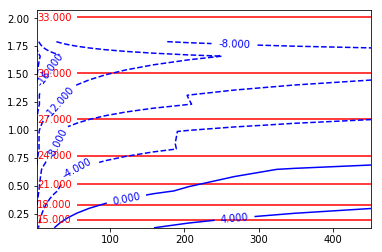

In [154]:
# plot contour map
fig, ax = plt.subplots()
CS = ax.contour(DPL/PC, MS/MSUN, AOPT/AU, colors='r')
CS2 = ax.contour(DPLIMAG/PC, MSIMAG/MSUN, IMAGREAL, colors='b')
ax.clabel(CS, inline=1, fontsize=10)
ax.clabel(CS2, inline=1, fontsize=10)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_title('')